### **Digital SongShu Project**
#### Last updated 2018-03-05 by Ruben G. Tsui

In [2]:
import json
from SongShu import SongShu
import re
import pandas as pd
from bs4 import BeautifulSoup
import altair

## SongShu -- tagging names, offices, places
##### <font color='red'>*Change your Songshu html data folder below*</font>

In [3]:
songshu = SongShu("2019-03-05", "RBT")
songshu.load_htmls(r'C:\NLP\Raft\Song shu-20181231T032348Z-001\data - Song shu')
songshu.extract_all()

INFO:root:Stop at loading C:\NLP\Raft\Song shu-20181231T032348Z-001\data - Song shu\SongShu_0851.html.
INFO:root:Total length of the data is 851.
ERROR:root:[Error] SongShu_rare_char.json does not exist

            try to run these lines: 
            	>> self.extract_rare_chars()
            	>> self.write_rare_chars()

INFO:root:Remove 標註, page number, and page dividers from the tree structure.
INFO:root:Remove the new lines added by the page dividers, connect the paragraphs before and after the new lines.


In [4]:
len(songshu.flat_bodies)

851

### Let's just deal with Scroll 001 for now

In [33]:
scroll001 = songshu.flat_bodies[0]  # 卷001

In [34]:
len(scroll001.html.body.span.find_all('div'))  # each <div> tag contains one paragraph 

67

In [35]:
paragraphs = [] # save each paragraph as an element in this list
for c in scroll001.html.body.span.find_all('div'):
    paragraphs.append(c.text)
    
sep = f"\n{'-'*60}\n"    ## paragraph separator (newline, -----, newline)
print(sep.join(paragraphs[:5]))

高祖武皇帝諱裕，字德輿，小名寄奴，彭城縣綏輿里人，漢高帝弟楚元王交之後也。交生紅懿侯富，富生宗正辟彊，辟彊生陽城繆侯德，德生陽城節侯安民，安民生陽城釐侯慶忌，慶忌生陽城肅侯岑，岑生宗正平，平生東武城令某，某生東萊太守景，景生明經洽，洽生博士弘，弘生瑯邪都尉悝，悝生魏定襄太守某，某生邪城令亮，亮生晉北平太守膺，膺生相國掾熙，熙生開封令旭孫。旭孫生混，始過江，居晉陵郡丹徒縣之京口里，官至武原令。混生東安太守靖，靖生郡功曹翹，是為皇考。高祖以晉哀帝興寧元年歲次癸亥三月壬寅夜生。及長，身長七尺六寸，風骨奇特。家貧，有大志，不治廉隅。事繼母以孝謹稱。
------------------------------------------------------------
初為冠軍孫無終司馬。安帝隆安三年十一月，妖賊孫恩作亂於會稽，晉朝衞將軍謝琰、前將軍劉牢之東討。牢之請高祖參府軍事。十二月，牢之至吳，而賊緣道屯結，牢之命高祖與數十人覘賊遠近。會遇賊至，眾數千人，高祖便進與戰。所將人多死，而戰意方厲，手奮長刀，所殺傷甚眾。牢之子敬宣疑高祖淹久，恐為賊所困，乃輕騎尋之。既而眾騎並至，賊乃奔退，斬獲千餘人，推鋒而進，平山陰，恩遁還入海。
------------------------------------------------------------
四年五月，恩復入會稽，殺衞將軍謝琰。十一月，劉牢之復率眾東征，恩退走。牢之屯上虞，使高祖戍句章城。句章城既卑小，戰士不盈數百人，高祖常被堅執銳，為士卒先，每戰輒摧鋒陷陣，賊乃退還浹口。于時東伐諸帥，御軍無律，士卒暴掠，甚為百姓所苦。唯高祖法令明整，所至莫不親賴焉。
------------------------------------------------------------
五年春，孫恩頻攻句章，高祖屢摧破之，恩復走入海。三月，恩北出海鹽，高祖追而翼之，築城于海鹽故治。賊日來攻城，城內兵力甚弱，高祖乃選敢死之士數百人，咸脫甲冑，執短兵，並鼓噪而出，賊震懼奪氣，因其懼而奔之，並棄甲散走，斬其大帥姚盛。雖連戰剋勝，然眾寡不敵，高祖獨深慮之。一夜，偃旗匿眾，若已遁者。明晨開門，使羸疾數人登城。賊遙問劉裕所在。曰：「夜已走矣。」賊信之，乃率眾大上。高祖乘其懈怠，奮擊，大破之。恩知城不可下，乃進向滬瀆。高祖復棄城追之。海鹽令鮑陋

#### Define tagging functions

In [5]:
def annotate_name(tagging_unit, df, col):
    '''
    This function annotates 'tagging_unit' (which is a paragraph for now) by matching the
    values from column 'col' in the dataframe 'df'; it then creates the tag
    <name id=''></name>, where the attribute id is from the "id" column of 'df'. 
    
    Inputs:
        tagging_unit = e.g. text of a paragraph
        df           = Pandas dataframe containing strings to be matched (e.g. names)
        col          = column name for the values to be matched
    Output:
        The function returns a string containing the tagged text
    
    Example usage:
       annotate_name(paragraph[0], bio_df, '姓名')
    '''
    tagged = ''
    tagged = tagging_unit
    for idx, row in df.iterrows():
        id_  = row['id'] # this is interpreted as the unique key to the dataframe 
        name = row[col]  # e.g. 姓名
        if name in tagged:
            tagged = tagged.replace(name, f"<name id='{id_}'>{name}</name>")
    return tagged

In [6]:
def annotate_office(tagging_unit, df, col):
    '''
    This function works similarly as annotate_name().
    
    Inputs:
       tagging_unit = e.g. text of a paragraph
       df           = Pandas dataframe containing strings to be matched (e.g. office)
       col          = column name for the values to be matched
       
    Example usage:
       annotate_name(paragraph[0], bio_df, 'Name') # 'Name' here corresponds to the column containing official tutles
    '''
    tagged = ''
    tagged = tagging_unit
    for idx, row in df.iterrows():
        id_  = row['ID'] # this is interpreted as the unique key to the dataframe 
        office = row[col]
        if office in tagged:
            tagged = tagged.replace(office, f"<office id='{id_}'>{office}</office>")
    return tagged

#### Read names, offices and places data from Excel worksheets

In [7]:
%%time
bio_df    = pd.read_excel("BioCombinedSortedTruncated.xlsx")  # This file has been processed previously
                                                              # requires no further actions
office_df = pd.read_excel("劉宋地名與官名 2017-11-14.xlsx", sheet_name="Offices")  # this will be sorted later
place_df  = pd.read_excel("劉宋地名與官名 2017-11-14.xlsx", sheet_name="Places")   # this will be sorted later

Wall time: 3.57 s


#### Define function to sort a dataframe by the length of value in a column, in descending order, so that longer string will match first.

In [8]:
def sort_by_length_of_indicated_column(df, col, ascending=False):
    s = df[col].str.len().sort_values(ascending=ascending).index
    df_out = df.reindex(s)
    return df_out

In [9]:
office_df = sort_by_length_of_indicated_column(office_df, 'Name')
place_df  = sort_by_length_of_indicated_column(place_df, 'Name')

In [10]:
office_df = office_df[:-7]  # remove last 7 entries, which are single-character official titles

In [11]:
office_df.tail()

,ID,Name
306,lso307,衛尉
309,lso310,廷尉
331,lso332,少府
330,lso331,甸師
319,lso320,太府


In [58]:
# collapse list into a single string for faster processing
sep = '|#|#|#|#|'  # paragraph separator
all_paragraphs = sep.join(paragraphs)

### Deal with variant characters

In [60]:
all_paragraphs = all_paragraphs.replace('衞','衛')

In [62]:
%%time
# annotate names
annotated = annotate_name(all_paragraphs, bio_df, '姓名')

Wall time: 7.12 s


In [113]:
%%time
# annotate offices
annotated = annotate_office(annotated, offices)

Wall time: 19.9 ms


In [114]:
annoteted_paragraphs = annotated.split(sep)

### Apply tagging on entire SongShu

In [12]:
sep = '|#|#|#|#|'  # paragraph separator
fo = open('songshu.all.names.offices.tagged.040-059.txt', 'w', encoding='utf-8', newline='\n')

i = 0
for section in songshu.flat_bodies[40:60]:
    #
    paragraphs = [] # for each section, save each paragraph as an element in this list
    for c in section.html.body.span.find_all('div'):
        paragraphs.append(c.text)
    all_paragraphs = sep.join(paragraphs)
    all_paragraphs = all_paragraphs.replace('衞','衛')
    annotated = annotate_name(all_paragraphs, bio_df, '姓名')
    annotated = annotate_office(annotated, office_df, 'Name')
    fo.write(f"Flat_bodies section {i}\n")
    for line in annotated.split(sep):
        fo.write(line + '\n')
    fo.write(f"{'-'*60}\n")
    i += 1
    if i % 5 == 0:
        print(f"processed {i} sections")
fo.close()

processed 5 sections
processed 10 sections
processed 15 sections
processed 20 sections


In [80]:
fo.close()

In [40]:
soup = BeautifulSoup('<tu>' + annoteted_paragraphs[1] + '</tu>', 'lxml')

In [43]:
myNames = soup.find_all('name')
len(myNames)

10

In [ ]:
soup = BeautifulSoup('<tu>' + annoteted_paragraphs[8] + '</tu>', 'lxml')
myNames = soup.find_all('name')
for person in myNames:
    print(person['id'], person.text)

## Extract Passages with Zhou, Jun

In [11]:
flat_bodies = []

for path,body in zip(songshu.paths, songshu.flat_bodies):
    if re.search(r"\／(['州郡']+)", path) != None:
        flat_bodies.append(body)
        
songshuGeo = SongShu(date='2018-8-21', creator='MF')
songshuGeo.filename = 'ShongShuGeo'
songshuGeo.flat_bodies = flat_bodies
songshuGeo.extract_paths()

In [25]:
songshuGeo.flat_bodies[0]

<html>
<body>
<a class="gobookmark" href="hanji?@96^1115717931^70^^^^@@682676597" title="開啟書籤管理">史／正史／宋書／志　凡三十卷／卷三十五　志第二十五／州郡一(P.1027)..[底本：宋元明三朝遞修本]</a>
<span id="fontstyle" style="FONT-SIZE: 12pt;letter-spacing:1pt; LINE-HEIGHT: 18pt;width:99%;word-break:break-all">
<b><h3>宋書卷三十五</h3></b><b><h3>　　志第二十五</h3></b><b><h3>　　　州郡一</h3></b><b><h3>　　　　揚州　南徐州　徐州　南兗州　兗州</h3></b><div style="text-indent:2em;padding-left:0em;">唐堯之世，置十有二牧，及禹平水土，更制九州，冀州堯都，土界廣遠，濟、河為兗州，海、岱為青州，海、岱及淮為徐州，淮、海為揚州，荊及衡陽為荊州，荊、河為豫州，華陽、黑水為梁州，黑水、西河為雍州。自虞至殷無所改變。周氏既有天下，以徐并青，以梁并雍，分冀州之地以為幽、并。漢初又立徐、梁二州。武帝攘卻胡、越，開地斥境，南置交趾，北置朔方，改雍曰涼，改梁曰益，凡為十三州，而司隸部三輔、三河諸郡。東京無復朔方，改交趾曰交州，凡十二州；司隸所部如故。及三國鼎跱，吳得揚、荊、交三州，蜀得益州，魏氏猶得九焉。吳又分交為廣。魏末平蜀，又分益為梁。晉武帝太康元年，天下一統，凡十有六州。後又分涼、雍為秦，分荊、揚為江，分益為寧，分幽為平，而為二十矣。</div>
<div style="text-indent:2em;padding-left:0em;">自夷狄亂華，司、冀、雍、涼、青、并、兗、豫、幽、平諸州一時淪沒，遺民南渡，並僑置牧司，非舊土也。江左又分荊為湘，或離或合，凡有揚、荊、湘、江、梁、益、交、廣，其徐州則有過半，豫州唯得譙城而已。及至宋世，分揚州為南徐，徐州為南兗，揚州之江西悉屬豫州，分荊為雍，分荊、湘為郢，分荊為司，分廣為越，分青為冀，分梁為南北秦。太宗初，索虜南侵，青、冀、徐、兗及豫州淮西，並皆不守，自淮以北，化成虜庭。於是於鍾離置徐州，淮陰為北兗，而

In [12]:
len(songshuGeo.flat_bodies)

23

## Get Rid of `page`, `a`, `span` tags

In [19]:
for j in songshuGeo.flat_bodies:
    for i in j.find_all("table", {"class":"page"}):
        i.extract()
    for i in j.find_all("a", {"href":"#"}):
        i.extract()
    for i in j.find_all("span", {"style":"display:none;width:;height:;color:red;font-size:13px"}):
        i.extract() 

## Get Rid of New Lines with No indentions

In [20]:
from bs4 import BeautifulSoup

# loop over body in flat_bodies:
for i,item in enumerate(songshuGeo.flat_bodies):
    # the item here is a bs4 object, so we need to convert it to a string
    string_item = str(item)
    
    # and then, substitute the regex pattern in the html source code in the item
    updated_string_item = re.sub(
        r'<\/div>([^\w]|\n)*?<div style="text-indent:0em;padding-left:0em;">', 
        r"", 
        string_item
    )
    
    # and then, we need to update the variable, item (with regex substituted), back into the flat_bodies list.
    # Note that the updated_string_item has to be converted to bs4 object
    songshuGeo.flat_bodies[i] = BeautifulSoup(updated_string_item, "lxml")

In [26]:
songshuGeo.pretty_print(22)

## Extraction of Numbers

In [17]:
songshuGeo

       type       variable                 method current_length
0      meta      flat_meta      self.extract_meta              0
1      path          paths     self.extract_paths             23
2  passages  flat_passages  self.extract_passages              0

In [22]:
zhou_csv = []

for i,item in enumerate(songshuGeo.flat_bodies):
    for match in re.finditer(
        r"([^>]*?)刺史，(.*(郡)([一二三四五六七八九十百千萬]+))?(.*(縣)([一二三四五六七八九十百千萬]+))?(.*(戶)([一二三四五六七八九十百千萬]+))?(.*(口)([一二三四五六七八九十百千萬]+))?(.*(水)([一二三四五六七八九十百千萬]+).*(陸)([一二三四五六七八九十百千萬]+))?", 
        str(item)
        ):
        print(i, [group for j,group in enumerate(match.groups()) if j != 1 and j != 4 and j != 7 and j != 10 and j != 13])
        zhou_csv.append((i, [group for j,group in enumerate(match.groups()) if j != 1 and j != 4 and j != 7 and j != 10 and j != 13]))

1 ['揚州', '郡', '十', '縣', '八十', '戶', '一十四萬三千二百九十六', '口', '一百四十五萬五千六百八十五', None, None, None, None]
2 ['南徐州', '郡', '十七', '縣', '六十三', '戶', '七萬二千四百七十二', '口', '四十二萬六百四十', '水', '二百四十', '陸', '二百']
3 ['徐州', '郡', '三', '縣', '九', None, None, None, None, '水', '一千三百六十', '陸', '一千']
4 ['南兗州', '郡', '十一', '縣', '四十四', None, None, None, None, '水', '二百五十', '陸', '一百八十']
5 ['兗州', '郡', '六', '縣', '三十一', '戶', '二萬九千三百四十', '口', '一十四萬五千五百八十一', None, None, None, None]
6 ['南豫州', '郡', '十九', '縣', '九十一', None, None, None, None, None, None, None, None]
7 ['豫州', '郡', '十', '縣', '四十三', '戶', '二萬二千九百一十九', '口', '一十五萬八百三十九', None, None, None, None]
8 ['江州', '郡', '九', '縣', '六十五', '戶', '五萬二千三十三', '口', '三十七萬七千一百四十七', None, None, None, None]
9 ['青州', '郡', '九', '縣', '四十六', '戶', '四萬五百四', '口', '四十萬二千七百二十九', None, None, None, None]
10 ['冀州', '郡', '九', '縣', '五十', '戶', '三萬八千七十六', '口', '一十八萬一千一', None, None, None, None]
11 ['司州', '郡', '四', '縣', '二十', None, None, None, None, '水', '二千七百', '陸', '一千七百']
12 ['荊州', '郡', '十二', '縣', '四十八', '戶', '

In [ ]:
jun_csv = []

for i,item in enumerate(songshuGeo.flat_bodies):
    for match in re.finditer(
        r"([^>]+?)(太守，|尹，|相，).*(縣)([一二三四五六七八九十百千萬]+).*(戶)([一二三四五六七八九十百千萬]+)(.*(口)([一二三四五六七八九十百千萬]+))?(.*(水)([一二三四五六七八九十百千萬]+).*(陸)([一二三四五六七八九十百千萬]+))?", 
        str(item)
        ):
        print(i, [group for j,group in enumerate(match.groups()) if j != 6 and j != 9])
        jun_csv.append((i, [group for j,group in enumerate(match.groups()) if j != 6 and j != 9]))

1 ['丹陽', '尹，', '縣', '八', '戶', '四萬一千一十', '口', '二十三萬七千三百四十一', None, None, None, None]
1 ['會稽', '太守，', '縣', '十', '戶', '五萬二千二百二十八', '口', '三十四萬八千一十四', None, None, None, None]
1 ['吳郡', '太守，', '縣', '十二', '戶', '五萬四百八十八', '口', '四十二萬四千八百一十二', '水', '六百七十', '陸', '五百二十']
1 ['吳興', '太守，', '縣', '十', '戶', '四萬九千六百九', '口', '三十一萬六千一百七十三', '水', '九百五十', '陸', '五百七十']
1 ['淮南', '太守，', '縣', '六', '戶', '五千三百六十二', '口', '二萬五千八百四十', '水', '一百七十', '陸', '一百四十']
1 ['宣城', '太守，', '縣', '十', '戶', '一萬一百二十', '口', '四萬七千九百九十二', '水', '五百八十', '陸', '五百']
1 ['東陽', '太守，', '縣', '九', '戶', '一萬六千二十二', '口', '一十萬七千九百六十五', None, None, None, None]
1 ['臨海', '太守，', '縣', '五', '戶', '三千九百六十一', '口', '二萬四千二百二十六', None, None, None, None]
1 ['永嘉', '太守，', '縣', '五', '戶', '六千二百五十', '口', '三萬六千六百八十', '水', '二千八百', '陸', '二千六百四十']
1 ['新安', '太守，', '縣', '五', '戶', '一萬二千五十八', '口', '三萬六千六百五十一', '水', '一千八百六十', '陸', '一千八百']
2 ['南東海', '太守，', '縣', '六', '戶', '五千三百四十二', '口', '三萬三千六百五十八', None, None, None, None]
2 ['南琅邪', '太守，', '縣', '二', '戶', '二千七百八十九', '口', '一萬八千六百九十

## NameTuple

In [ ]:
from collections import namedtuple

Jun = namedtuple("郡", ["Name", "縣", "戶", "口", "水", "陸", "州"])
Jun(Name="合浦", 縣='七', 戶='九百三十八', 口=None, 水=None, 陸=None, 州="廣州")

Zhou = namedtuple("州", ["Name", "郡", "縣", "戶", "口", "水", "陸", "data"])
Zhou(
    Name="廣州", 
    郡='十七', 
    縣='一百三十六', 
    戶='四萬九千七百二十六', 
    口='二十萬六千六百九十四', 
    水=None, 
    陸=None,  
    data=[Jun(Name="合浦", 縣='七', 戶='九百三十八', 口=None, 水=None, 陸=None,  州="廣州"), 
          Jun(Name="日南", 縣='七', 戶='四百二', 口=None, 水=None, 陸=None,  州="廣州")]
)

州(Name='廣州', 郡='十七', 縣='一百三十六', 戶='四萬九千七百二十六', 口='二十萬六千六百九十四', 水=None, 陸=None, data=[郡(Name='合浦', 縣='七', 戶='九百三十八', 口=None, 水=None, 陸=None, 州='廣州'), 郡(Name='日南', 縣='七', 戶='四百二', 口=None, 水=None, 陸=None, 州='廣州')])

## CNum to Num

In [23]:
import pycnnum

In [24]:
pycnnum.cn2num("一百三十六", numbering_type="mid")

136

In [ ]:
pycnnum.cn2num("四萬九千七百二十六", numbering_type="mid")

49726

In [ ]:
pycnnum.cn2num("二十萬六千六百九十四", numbering_type="mid")

206694

## Organize the Zhou, Jun Data

In [ ]:
def cn2num(string):
    if string != None:
        return pycnnum.cn2num(string)  
    else: return None

Zhou_list = []

for zhou_row in zhou_csv:
    index, (name, _, jun_num, _, shan_num, _, hu_num, _, ko_num, _, water_num, _, groud_num) = zhou_row
    Zhou_list.append(Zhou(
        Name=name, 
        郡=cn2num(jun_num), 
        縣=cn2num(shan_num), 
        戶=cn2num(hu_num), 
        口=cn2num(ko_num), 
        水=cn2num(water_num), 
        陸=cn2num(groud_num), 
        data=[]
    ))
    
    
Jun_list = []

for jun_row in jun_csv:
    index, (name, _,_, shan_num, _, hu_num, _, ko_num, _, water_num, _, groud_num) = jun_row
    jun = Jun(
        Name=name, 
        縣=cn2num(shan_num), 
        戶=cn2num(hu_num), 
        口=cn2num(ko_num), 
        水=cn2num(water_num), 
        陸=cn2num(groud_num),         
        州=Zhou_list[index - 1].Name
    )
    Zhou_list[index - 1].data.append(jun)
    Jun_list.append(jun)

## Zhou Viz

In [ ]:
df = pd.DataFrame(Zhou_list)
df

,Name,郡,縣,戶,口,水,陸,data
0,揚州,10.0,80.0,143296.0,1455685.0,NaN,NaN,"[(丹陽, 8, 41010, 237341, None, None, 揚州), (會稽, ..."
1,南徐州,17.0,63.0,72472.0,420640.0,240.0,200.0,"[(南東海, 6, 5342, 33658, None, None, 南徐州), (南琅邪,..."
2,徐州,3.0,9.0,NaN,NaN,1360.0,1000.0,"[(彭城, 5, 8627, 41231, None, None, 徐州), (沛郡, 3,..."
3,南兗州,11.0,44.0,NaN,NaN,250.0,180.0,"[(廣陵, 4, 7744, 45613, None, None, 南兗州), (海陵, 6..."
4,兗州,6.0,31.0,29340.0,145581.0,NaN,NaN,"[(泰山, 8, 8177, 45581, None, None, 兗州), (高平, 6,..."
5,南豫州,19.0,91.0,NaN,NaN,NaN,NaN,"[(歷陽, 5, 3156, 19470, None, None, 南豫州), (南譙, 6..."
6,豫州,10.0,43.0,22919.0,150839.0,NaN,NaN,"[(汝南, 11, 11291, 89349, 3000, 1500, 豫州), (新蔡, ..."
7,江州,9.0,65.0,52033.0,377147.0,NaN,NaN,"[(尋陽, 3, 2720, 16800, None, None, 江州), (豫章, 12..."
8,青州,9.0,46.0,40540.0,402729.0,NaN,NaN,"[(齊郡, 7, 7346, 4889, None, None, 青州), (濟南, 6, ..."
9,冀州,9.0,50.0,38076.0,181100.0,NaN,NaN,"[(廣川, 4, 3250, 23614, None, None, 冀州), (平原, 8,..."


In [ ]:
df = pd.DataFrame(Zhou_list)
df.columns = ['Name', 'jun', 'xian', 'hu', 'kou', 'shui', 'lu', 'data']
#df = df.dropna(subset=['hu'])
df['average_house'] = df['kou'] / df['hu']
df['kou_in_jun'] = [
    sum([t.口 for t in data if t.口 != None]) for data in df['data']
]
df['hu_in_jun'] = [
    sum([t.戶 for t in data if t.戶 != None]) for data in df['data']
]

df['zhou_kou_minus_jun_total_kou'] = df['kou'] - df['kou_in_jun']
df['zhou_hu_minus_jun_total_hu']   = df['hu'] - df['hu_in_jun']
df['average_house_jun_total'] = df['kou_in_jun'] / df['hu_in_jun']

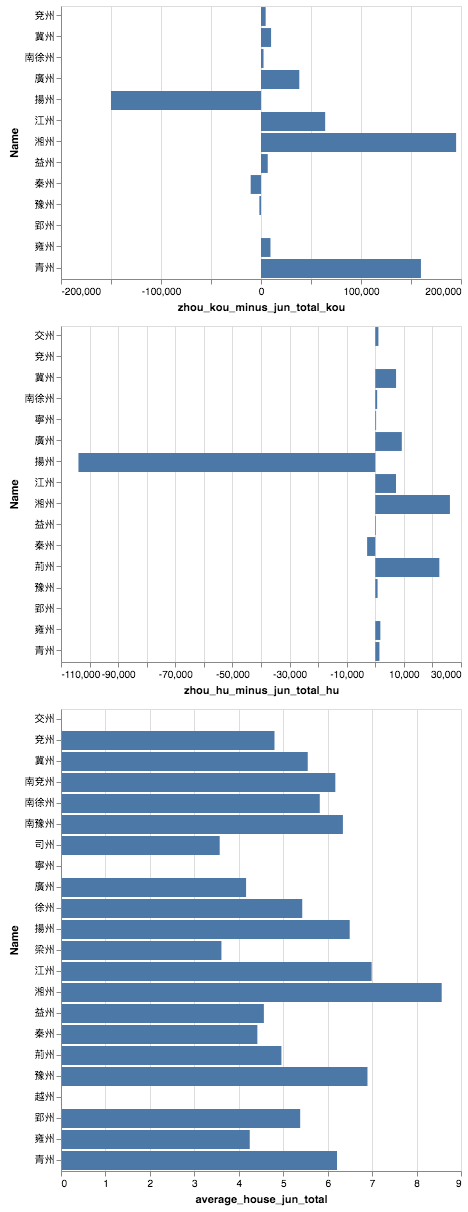

In [ ]:
bar1 = altair.Chart(df).mark_bar().encode(
    y="Name",
    x="zhou_kou_minus_jun_total_kou",
    tooltip=["Name"]
)

bar2 = altair.Chart(df).mark_bar().encode(
    y="Name",
    x="zhou_hu_minus_jun_total_hu",
    tooltip=["Name"]
)

bar3 = altair.Chart(df).mark_bar().encode(
    y="Name",
    x="average_house_jun_total",
    tooltip=["Name"]
)


bar1 & bar2 & bar3

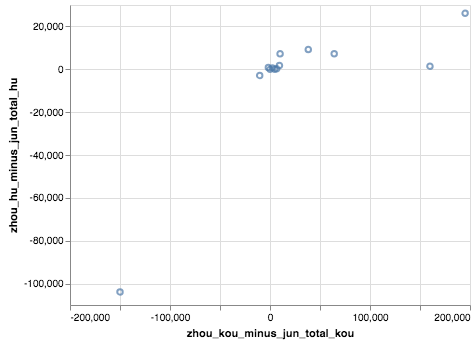

In [ ]:
point = altair.Chart(df).mark_point().encode(
    x="zhou_kou_minus_jun_total_kou",
    y="zhou_hu_minus_jun_total_hu",
    tooltip=["Name"]
)

point

In [ ]:
df_zhou = pd.DataFrame(Zhou_list)
df_zhou.columns = ['Name', 'jun', 'xian', 'hu', 'kou', 'shui', 'lu', 'data']

In [ ]:
bar_list = []

for i in range(len(df_zhou)):
    test = pd.DataFrame(df_zhou.loc[i, ['jun', 'xian', 'hu', 'kou', 'shui', 'lu']])
    test.columns = ['data']
    test['names'] =  test.index
    test

    bar_list.append(
        altair.Chart(test, title=df_zhou.loc[i,'Name']).mark_bar().encode(
            x='names',
            y='data'
        )
    )

In [ ]:
"|".join(["bar_list[{}]".format(i) for i in range(len(bar_list))])

'bar_list[0]|bar_list[1]|bar_list[2]|bar_list[3]|bar_list[4]|bar_list[5]|bar_list[6]|bar_list[7]|bar_list[8]|bar_list[9]|bar_list[10]|bar_list[11]|bar_list[12]|bar_list[13]|bar_list[14]|bar_list[15]|bar_list[16]|bar_list[17]|bar_list[18]|bar_list[19]|bar_list[20]|bar_list[21]'

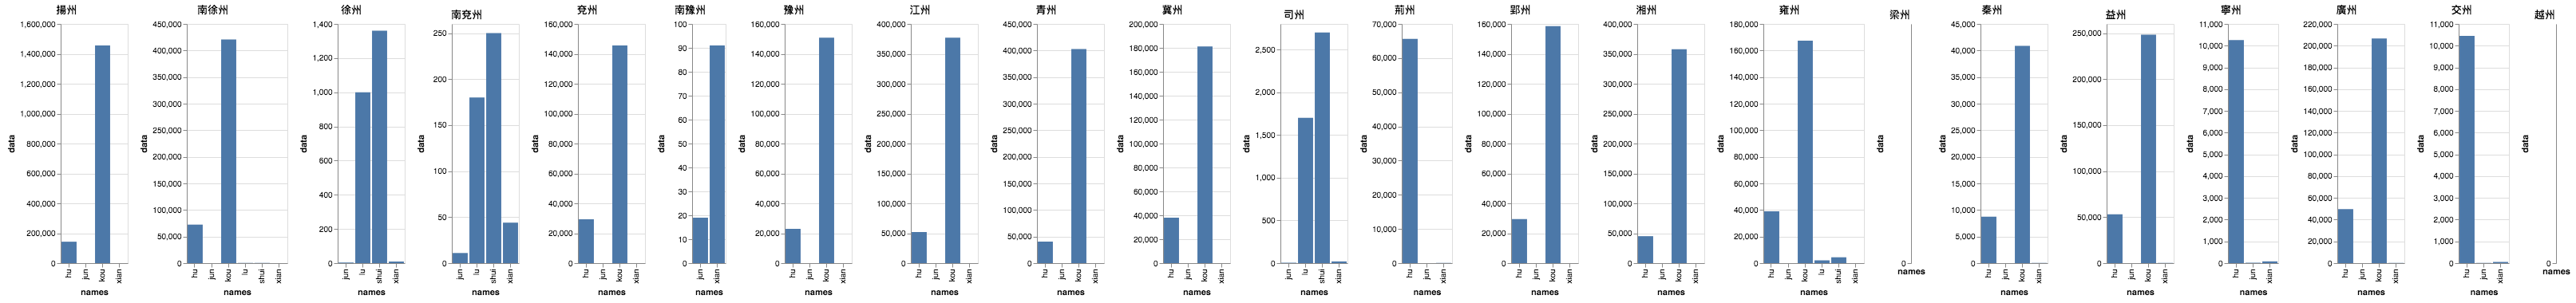

In [ ]:
bar_list[0]|bar_list[1]|bar_list[2]|bar_list[3]|bar_list[4]|bar_list[5]|bar_list[6]|bar_list[7]|bar_list[8]|bar_list[9]|bar_list[10]|bar_list[11]|bar_list[12]|bar_list[13]|bar_list[14]|bar_list[15]|bar_list[16]|bar_list[17]|bar_list[18]|bar_list[19]|bar_list[20]|bar_list[21]

## Jun Viz

In [ ]:
df_jun = pd.DataFrame(Jun_list)
df_jun.columns = ['Name', 'xian', 'hu', 'kou', 'shui', 'lu', 'zhou']
df_jun

,Name,xian,hu,kou,shui,lu,zhou
0,丹陽,8,41010,237341.0,NaN,NaN,揚州
1,會稽,10,52228,348014.0,NaN,NaN,揚州
2,吳郡,12,50488,424812.0,670.0,520.0,揚州
3,吳興,10,49690,316173.0,950.0,570.0,揚州
4,淮南,6,5362,25840.0,170.0,140.0,揚州
5,宣城,10,10120,47992.0,580.0,500.0,揚州
6,東陽,9,16022,107965.0,NaN,NaN,揚州
7,臨海,5,3961,24226.0,NaN,NaN,揚州
8,永嘉,5,6250,36680.0,2800.0,2640.0,揚州
9,新安,5,12058,36651.0,1860.0,1800.0,揚州


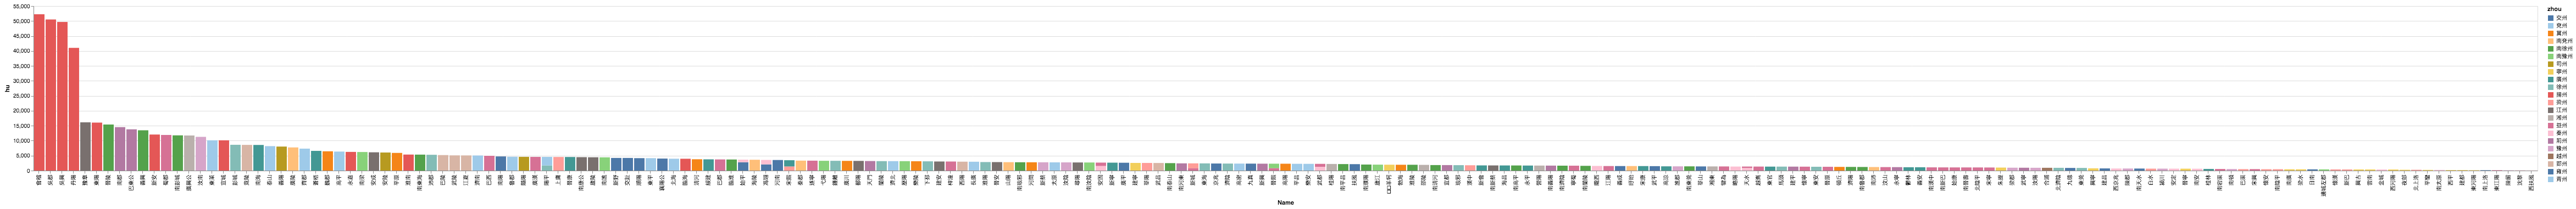

In [ ]:
altair.Chart(df_jun).mark_bar().encode(
    x=altair.X("Name", sort=altair.SortField(field="hu", op="sum", order="descending")),
    y="hu",
    color=altair.Color("zhou", scale=altair.Scale(scheme="tableau20")),
    tooltip=['Name', 'xian', 'hu', 'kou', 'shui', 'lu', 'zhou']
)

In [ ]:
songshuGeo[1]

In [ ]:
from IPython.display import HTML

HTML('<font style="color: k; background-color: #ffff42">揚州</font>')